# Credit Fraud Detector

## Load Dependencies

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

## Load Data

Dataset description:

| Feature|  Description|
|--:|:--|
Time | Number of seconds elapsed between this transaction and the first transaction in the dataset | 
V1 - V28 | may be result of a PCA Dimensionality reduction to protect user identities and sensitive features | 
Amount | Transaction amount | 
Class | 1 for fraudulent transactions, 0 otherwise | 

In [2]:
dataset = pd.read_csv("creditcard.csv")
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
print(dataset.shape[0], "rows and ", dataset.shape[1], "columns")

284807 rows and  31 columns


## Data prep

In [4]:
# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

dataset['scaled_amount'] = rob_scaler.fit_transform(dataset['Amount'].values.reshape(-1,1))
dataset['scaled_time'] = rob_scaler.fit_transform(dataset['Time'].values.reshape(-1,1))

dataset.drop(['Time','Amount'], axis=1, inplace=True)

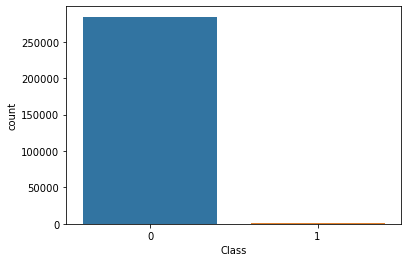

In [5]:
sns.countplot('Class', data=dataset)

In [6]:
print('Distribution of the Classes in the subsample dataset')
print(dataset['Class'].value_counts()/len(dataset))

Distribution of the Classes in the subsample dataset
0    0.998273
1    0.001727
Name: Class, dtype: float64


# Modeling

In [7]:
X = dataset.drop('Class', axis=1)
y = dataset['Class']

In [8]:
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [10]:
# Let's implement simple classifiers

classifiers = {
    "LogisticRegression": LogisticRegression(penalty="none", class_weight=None, random_state = 42, n_jobs = -1, verbose = 0),
    "LogisticRegressionWtd": LogisticRegression(penalty="none", class_weight="balanced", random_state = 42, n_jobs = -1, verbose = 0),
    "LogisticRegressionLasso": LogisticRegression(penalty="l1", solver = "saga", class_weight="balanced", random_state = 42, n_jobs = -1, verbose = 0)
}

In [11]:
# Wow our scores are getting even high scores even when applying cross validation.

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5, scoring= "f1")
    print("Classifiers: ", key, "Has a training score of", round(training_score.mean(), 4) * 100, "% f1 score")
    

Classifiers:  LogisticRegression Has a training score of 73.48 % f1 score
Classifiers:  LogisticRegressionWtd Has a training score of 11.73 % f1 score
Classifiers:  LogisticRegressionLasso Has a training score of 12.26 % f1 score


In [12]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {'l1_ratio': np.linspace(0, 1, 30)}

grid_log_reg = GridSearchCV(LogisticRegression(class_weight="balanced", random_state = 42), log_reg_params, scoring = "f1", verbose = 1,  n_jobs = -1)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

log_reg

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.8min finished


In [13]:
log_reg

LogisticRegression(class_weight='balanced', l1_ratio=0.0, random_state=42)

l1_ratio=0 is equivalent to using penalty='l2' (Ridge)

In [14]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5, scoring= "f1")
print('Logistic Regression Cross Validation f1 Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation f1 Score:  97.62%


# Predict new data

In [41]:
# Criando o modelo
model = log_reg
model.fit(X_train, y_train)

# Fazendo as previsões e construindo o relatório
fitted = model.predict(X_test)

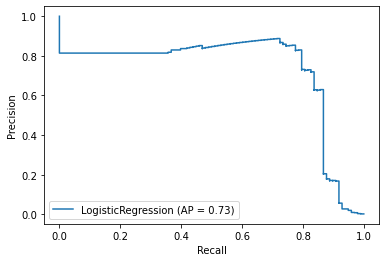

In [42]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(log_reg, X_test, y_test)

In [16]:
# Confusion Matrix
matrix = confusion_matrix(y_test, fitted)

# Imprimindo a Confusion Matrix
print(matrix)

tn, fp, fn, tp = confusion_matrix(y_test, fitted, normalize='true').ravel()
{"True Negative" : round(tn, 4), "False Positive" : round(fp, 4), "False Negative" : round(fn, 4),"True Positive" : round(tp, 4)}


[[55525  1339]
 [    8    90]]


{'True Negative': 0.9765,
 'False Positive': 0.0235,
 'False Negative': 0.0816,
 'True Positive': 0.9184}

In [17]:
report = classification_report(y_test, fitted)

# Imprimindo o relatório
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



## LightGBM

In [35]:
import lightgbm

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot



In [36]:
LGBMmodel = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(LGBMmodel, X_train, y_train, scoring= "f1", cv=cv, n_jobs=-1, error_score='raise')
print('F1: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


F1: 0.277 (0.160)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


In [37]:
# Criando o modelo
LGBMmodel.fit(X_train, y_train)

LGBMClassifier()

In [38]:
# Fazendo as previsões e construindo o relatório
fitted = LGBMmodel.predict(X_test)

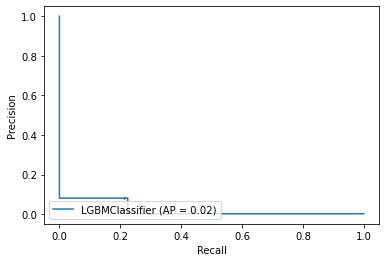

In [39]:
disp = plot_precision_recall_curve(LGBMmodel, X_test, y_test)

In [40]:
# Confusion Matrix
matrix = confusion_matrix(y_test, fitted)

# Imprimindo a Confusion Matrix
print(matrix)

tn, fp, fn, tp = confusion_matrix(y_test, fitted, normalize='true').ravel()
{"True Negative" : round(tn, 4), "False Positive" : round(fp, 4), "False Negative" : round(fn, 4),"True Positive" : round(tp, 4)}


[[56584   280]
 [   76    22]]


{'True Negative': 0.9951,
 'False Positive': 0.0049,
 'False Negative': 0.7755,
 'True Positive': 0.2245}

## CatBoost

In [ ]:
# catboost for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
model = CatBoostClassifier(verbose=0, n_estimators=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = CatBoostClassifier(verbose=0, n_estimators=100)
model.fit(X, y)
# make a single prediction
row = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
yhat = model.predict(row)
print('Prediction: %d' % yhat[0])